# Big Data (UBA) -  2024

## Trabajo Práctico 2

### Fecha de entrega:
<font color='red'> Viernes 29 de Noviembre a las 13:00 hs </font>

In [1]:
# Instalacion de paquetes/librerias

import requests
import json
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from bs4 import BeautifulSoup
import locale
import datetime
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde


### Parte I: Analizando la base

#### 1.	Utilizando información disponible en la pagina del INDEC, expliquen brevemente como se identifica a las personas desocupadas.

#### Para responder esta pregunta es necesario mencionar al concepto de Población Economicamente Activa. La PEA esta formado por la gente que tiene posibilidades legales y fisicas de trabajar. Son hombres y mujeres entre 16 y 65 años, con una ocupación o que, sin tenerla, la buscan activamente y están disponibles para trabajar. Por ende, dentro de la PEA se encuentran los ocupados y desocupados. Los desocupados son personas que no tienen ocupación, están disponibles para trabajar y buscan empleo activamente. El dato de buscar un trabajo de forma activa es clave en la noción, ya que si no lo buscaran, formarían parte de la poblacion inactiva.

#### 2.	Entren a la pagina https://www.indec.gob.ar/ y vayan a la sección Servicios y Herramientas -> Bases de datos. Descarguen la base de microdatos de la Encuesta Permanente de Hogares (EPH) correspondiente al primer trimestre de 2004 y 2024 en formato .dta y .xls, respectivamente (una vez descargadas, las bases a usar son Individual_t104.dta y usu_individual_T124.xls). En la pagina web, también encontrara un diccionario de variables con el nombre de “Diseño de registro y estructura para las bases preliminares (hogares y personas)”. Descarguen el diccionario de cada año. En estos archivos se les indica qué significa cada variable que aparece en la base de datos, en particular, en la sección de Diseño de registros de la base Personas.

In [5]:
# Leer la base de datos para 2024 (archivo .xls)
df_2024 = pd.read_excel('/content/usu_individual_T124.xlsx')

# Leer la base de datos para 2004 (archivo .dta)
df_2004 = pd.read_stata('/content/Individual_t104.dta')

In [6]:
# Revisión de las primeras filas de ambos dataframes
print(df_2024.head())  # Para 2024
print(df_2004.head())  # Para 2004

                          CODUSU  ANO4  TRIMESTRE  NRO_HOGAR  COMPONENTE  H15  \
0  TQRMNOPUTHLMKQCDEGGFB00852588  2024          1          1           3    1   
1  TQRMNOPUTHLMKQCDEGGFB00852588  2024          1          1           4    1   
2  TQRMNOPUTHLMKQCDEGGFB00852588  2024          1          1           5    0   
3  TQRMNOPPWHLLKRCDEGGFB00852574  2024          1          1           1    1   
4  TQRMNOPPWHLLKRCDEGGFB00852574  2024          1          1           2    1   

   REGION MAS_500  AGLOMERADO  PONDERA  ...  PDECIFR  ADECIFR      IPCF  \
0      42       S          10      439  ...      NaN       12       0.0   
1      42       S          10      439  ...      NaN       12       0.0   
2      42       S          10      439  ...      NaN       12       0.0   
3      42       S          10      675  ...      NaN        8  212500.0   
4      42       S          10      675  ...      NaN        8  212500.0   

   DECCFR  IDECCFR  RDECCFR  GDECCFR  PDECCFR  ADECCFR  PONDIH

##### 2a.	Eliminen todas las observaciones que no corresponden a los aglomerados de Ciudad Autónoma de Buenos Aires (CABA) o Partidos del Gran Buenos Aires, y unan ambos trimestres en una sola base.

In [7]:
# Filtrar las observaciones para CABA (AGLOMERADO = 32) y GBA (AGLOMERADO = 33) en 2024
df_2024_caba_gba = df_2024[df_2024['AGLOMERADO'].isin([32,33])]

# Filtrar las observaciones para CABA (AGLOMERADO = "Ciudad de Buenos Aires") y GBA (AGLOMERADO = "Partidos del GBA") en 2004
df_2004_caba_gba = df_2004[df_2004['aglomerado'].isin(['Ciudad de Buenos Aires','Partidos del GBA'])]

# Unir ambos trimestres

## Paso las variables de 2004 a mayusculas para que haga el concat de manera correcta

df_2004_caba_gba.columns = df_2004_caba_gba.columns.str.upper()

## Algunas variables de la EPH 2004 tienen datos en STR. Las paso al mismo codigo numerico
## que la EPH 2024

reemplazos = {
    'CH04': {'Varón': 1, 'Mujer': 2},
    'CH06': {'Menos de 1 año': 0.5,'98 y más años': 99},
    'CH07': {'Unido': 1, 'Soltero': 5, 'Casado': 2,'Separado o divorciado': 3, 'Viudo': 4},
    'CH08': {
        'Obra social (incluye PAMI)': 1,
        'No paga ni le descuentan': 4,
        'Mutual/Prepaga/Servicio de emergencia': 2,
        'Obra social y mutual/prepaga/servicio de emergencia': 12,
        'Planes y seguros públicos': 3,
        'Ns./Nr.': 9,
        'Mutual/prepaga/servicio de emergencia/planes y seguros públi': 23
    },
    'NIVEL_ED': {
        'Secundaria Incompleta': 3,
        'Primaria Completa': 2,
        'Superior Universitaria Completa': 6,
        'Superior Universitaria Incompleta': 5,
        'Secundaria Completa': 4,
        'Primaria Incompleta (incluye educación especial)': 1,
        'Sin instrucción': 7
    },
    'ESTADO': {
        'Inactivo': 3,
        'Ocupado': 1,
        'Desocupado': 2,
        'Menor de 10 años': 4,
        'Entrevista individual no realizada (no respuesta al cuestion': 0
    },
    'CAT_INAC': {
        'Jubilado/pensionado': 1,
        '0': 0,
        'Ama de casa': 4,
        'Estudiante': 3,
        'Menor de 6 años': 5,
        'Rentista': 2,
        'Otros': 7,
        'Discapacitado': 6
    }
}

# Aplicar los reemplazos al DataFrame
for columna, cambios in reemplazos.items():
    if columna in df_2004_caba_gba.columns:  # Verificar que la columna existe en el DataFrame
        df_2004_caba_gba[columna] = df_2004_caba_gba[columna].replace(cambios)
    else:
      print(f"La columna '{columna}' no existe en el DataFrame.")

## uno ambas EPH

df_unido = pd.concat([df_2004_caba_gba, df_2024_caba_gba], ignore_index=True)

<ipython-input-7-2f1bee2ed7bc>:60: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_2004_caba_gba[columna] = df_2004_caba_gba[columna].replace(cambios)
<ipython-input-7-2f1bee2ed7bc>:60: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_2004_caba_gba[columna] = df_2004_caba_gba[columna].replace(cambios)
<ipython-input-7-2f1bee2ed7bc>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

##### b.	Si hay observaciones con valores que no tienen sentido, descártenlas (por ejemplo, ingresos y edades negativos). Expliquen las decisiones tomadas.

In [47]:
# Eliminar observaciones con ingresos y edades negativos. Cambiamos las edades
# "Menos de 1 año" por 0.5 y "98 y más años" por 99

df_limpieza = df_unido[df_unido['ITF'] >= 0]

df_limpieza = df_limpieza[df_limpieza['IPCF'] >= 0]

df_limpieza = df_limpieza[df_limpieza['CH06'] >= 0]


##### c.	Una vez hecha esa limpieza, realicen un gráfico de barras mostrando la composición por sexo para 2004 y 2024. Comenten los resultados.

[1, 2]
Categories (2, int64): [1 < 2]
[2 1]


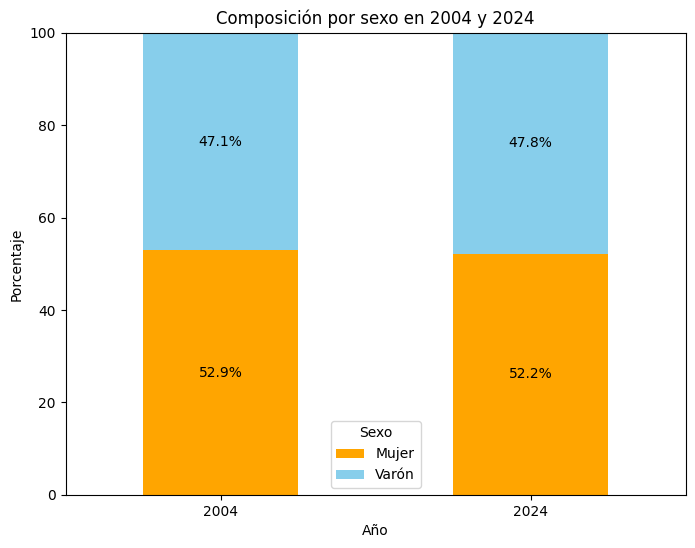

In [48]:
# Chequeo los valores unicos

print(df_2004_caba_gba['CH04'].unique())
print(df_2024_caba_gba['CH04'].unique())

# Hago un remapeo de la variable sexo CH04

map_sexo = {1: 'Varón', 2: 'Mujer'}

df_2004_caba_gba_sexo = df_2004_caba_gba['CH04'].map(map_sexo)
df_2024_caba_gba_sexo = df_2024_caba_gba['CH04'].map(map_sexo)

# Calcular porcentajes para 2004
df_2004_sexo = df_2004_caba_gba_sexo.value_counts(normalize=True) * 100
# Calcular porcentajes para 2024
df_2024_sexo = df_2024_caba_gba_sexo.value_counts(normalize=True) * 100

# Pasamos al grafico de barras apiladas con los años 2004 y 2024

# Crear un DataFrame con los datos combinados
df_barras = pd.DataFrame({
    '2004': df_2004_sexo,
    '2024': df_2024_sexo
}).T  # Transponer para que los años sean las filas

# Crear el gráfico de barras apiladas
fig, ax = plt.subplots(figsize=(8, 6))
bars = df_barras.plot(kind='bar', stacked=True, ax=ax, color=['orange', 'skyblue'])

# Añadir los porcentajes en cada barra
for i, p in enumerate(bars.patches):  # Recorremos las barras
    height = p.get_height()  # Altura de la barra
    width = p.get_width()  # Ancho de la barra
    x = p.get_x() + width / 2  # Posición X para colocar el texto (centrado)
    y = p.get_y() + height / 2  # Posición Y (centrado verticalmente)
    ax.text(x, y, f'{height:.1f}%', ha='center', va='center', fontsize=10, color='black')

# Personalizar el gráfico
ax.set_title('Composición por sexo en 2004 y 2024')
ax.set_xlabel('Año')
ax.set_ylabel('Porcentaje')
ax.legend(title='Sexo')
ax.set_ylim(0, 100)  # Asegurarse de que las barras sumen hasta 100%
plt.xticks(rotation=0)  # Mantener las etiquetas de los años horizontales

# Mostrar el gráfico
plt.show()

##### d.	Realicen una matriz de correlación para 2004 y 2024 con las siguientes variables: CH04, CH06, CH07, CH08, NIVEL ED, ESTADO, CAT_INAC, IPCF. Utilicen alguno de los comandos disponibles en este link o este link para graficar la matriz de correlación. Comenten los resultados.

<ipython-input-49-8ce991f11474>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2004_caba_gba_corr['CH04'] = df_2004_caba_gba_corr['CH04'].replace({'Varón': 1, 'Mujer': 2})
<ipython-input-49-8ce991f11474>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2004_caba_gba_corr['CH06'] = df_2004_caba_gba_corr['CH06'].replace("Menos de 1 año", 0.5)
<ipython-input-49-8ce991f11474>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

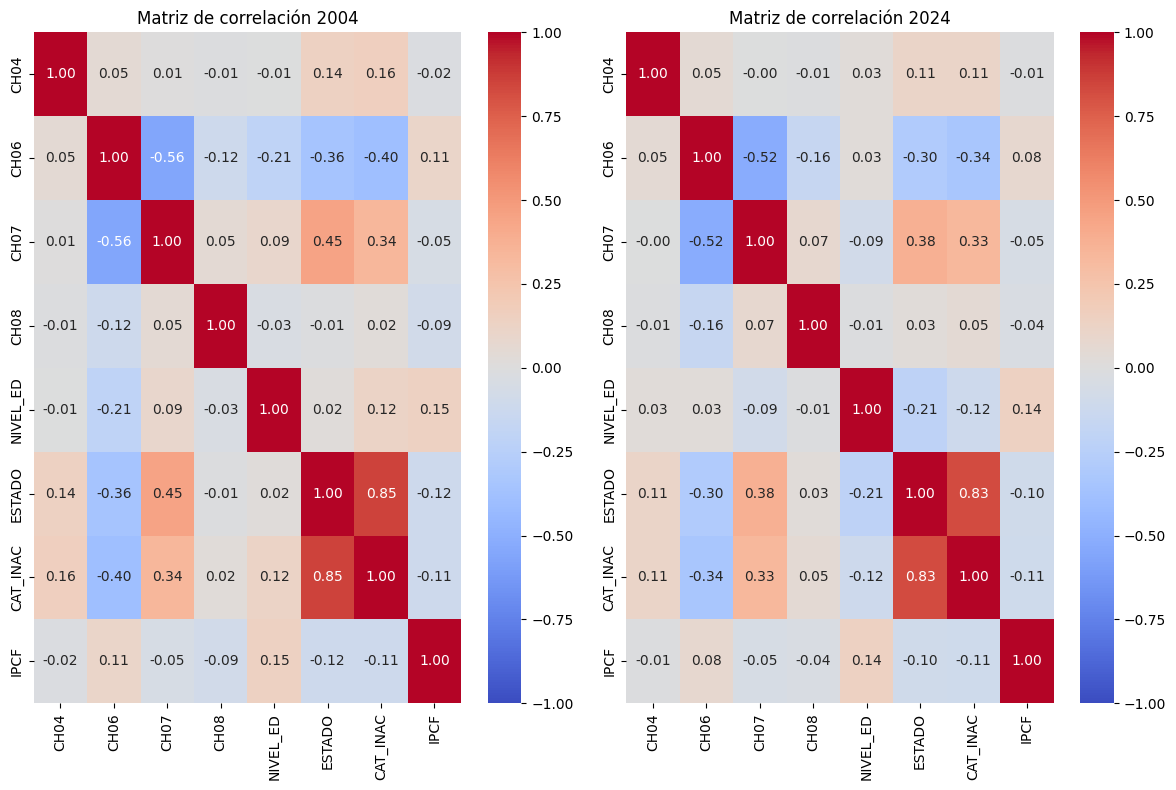

In [49]:
# Creo unos DataFrames nuevos

df_2004_caba_gba_corr= df_2004_caba_gba
df_2004_caba_gba_corr['CH04'] = df_2004_caba_gba_corr['CH04'].replace({'Varón': 1, 'Mujer': 2})

df_2004_caba_gba_corr['CH06'] = df_2004_caba_gba_corr['CH06'].replace("Menos de 1 año", 0.5)
df_2004_caba_gba_corr['CH06'] = df_2004_caba_gba_corr['CH06'].replace("98 y más años", 99)

# Selección de columnas
variables = ['CH04', 'CH06', 'CH07', 'CH08', 'NIVEL_ED', 'ESTADO', 'CAT_INAC', 'IPCF']

# Matriz de correlación para 2004

corr_2004 = df_2004_caba_gba_corr[variables].corr()

# Matriz de correlación para 2024
corr_2024 = df_2024_caba_gba[variables].corr()

# Graficar las matrices de correlación
plt.figure(figsize=(12, 8))

# Correlación 2004
plt.subplot(1, 2, 1)
sns.heatmap(corr_2004, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Matriz de correlación 2004')

# Correlación 2024
plt.subplot(1, 2, 2)
sns.heatmap(corr_2024, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Matriz de correlación 2024')

plt.tight_layout()
plt.show()


##### e.	¿Cuántos desocupados hay en la muestra? ¿Cuántos inactivos? ¿Cuál es la media de ingreso per cápita familiar (IPCF) según estado (ocupado, desocupado, inactivo)?

In [51]:
# Contar los desocupados e inactivos
desocupados = df_limpieza[df_limpieza['ESTADO'] == 2].shape[0]
inactivos = df_limpieza[df_limpieza['ESTADO'] == 3].shape[0]

# Calcular la media de IPCF por estado
media_ipcf = df_limpieza.groupby('ESTADO')['IPCF'].mean()

# Resultados
print(f"Cantidad de Desocupados: {desocupados}")
print(f"Cantidad de Inactivos: {inactivos}")
print(f"Media de IPCF Ocupados: {media_ipcf[1]:.1f}")
print(f"Media de IPCF Desocupados: {media_ipcf[2]:.1f}")
print(f"Media de IPCF Inactivos: {media_ipcf[3]:.1f}")

Cantidad de Desocupados: 839
Cantidad de Inactivos: 5462
Media de IPCF Ocupados: 106443.4
Media de IPCF Desocupados: 31656.0
Media de IPCF Inactivos: 63863.1


#### 3.	Uno de los grandes problemas de la EPH es la creciente cantidad de hogares que no reportan sus ingresos (ver por ejemplo el siguiente informe). ¿Cuántas personas no respondieron cual es su condición de actividad? Guarden como una base distinta llamada respondieron las observaciones donde respondieron la pregunta sobre su condición de actividad (ESTADO). Las observaciones con ESTADO=0 guárdenlas en una base bajo el nombre norespondieron.

In [52]:
# Filtrar las observaciones donde respondieron la condición de actividad
respondieron = df_limpieza[df_limpieza['ESTADO'] != 0]

# Filtrar las observaciones donde no respondieron la condición de actividad
norespondieron = df_limpieza[df_limpieza['ESTADO'] == 0]

# Ver el número de personas que no respondieron
print(f"Cantidad de personas que no respondieron: {norespondieron.shape[0]}")


Cantidad de personas que no respondieron: 51


#### 4.	Agreguen a la base respondieron una columna llamada PEA (Población Económicamente Activa) que tome 1 si están ocupados o desocupados en ESTADO. Realicen un gráfico de barras mostrando la composición por PEA para 2004 y 2024. Comenten los resultados.

<ipython-input-53-b81b5a5c2fab>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron['PEA'] = respondieron['ESTADO'].apply(lambda x: 1 if x in [1, 2] else 0)


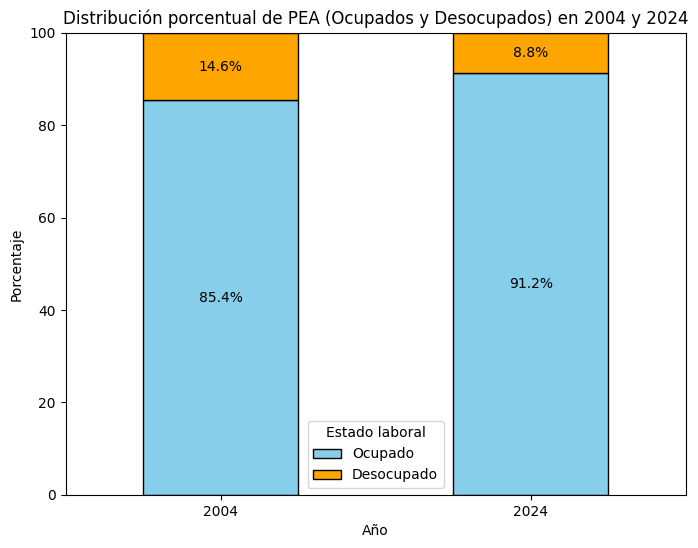

In [53]:
# Agregar la columna PEA (Población Económicamente Activa)
respondieron['PEA'] = respondieron['ESTADO'].apply(lambda x: 1 if x in [1, 2] else 0)

# Ver las primeras filas para comprobar
respondieron[['ESTADO', 'PEA']].head()

# Filtrar los datos por año
df_2004_pea = respondieron[(respondieron['PEA'] == 1) & (respondieron['ANO4'] == 2004)]
df_2024_pea = respondieron[(respondieron['PEA'] == 1) & (respondieron['ANO4'] == 2024)]

# Calcular porcentajes para cada estado en 2004
pea_2004 = df_2004_pea['ESTADO'].value_counts(normalize=True) * 100

# Calcular porcentajes para cada estado en 2024
pea_2024 = df_2024_pea['ESTADO'].value_counts(normalize=True) * 100

# Crear un DataFrame con los datos combinados
df_barras_pea = pd.DataFrame({
    '2004': pea_2004,
    '2024': pea_2024
}).T  # Transponer para que los años sean las filas

# Renombrar columnas para que queden claras
df_barras_pea.rename(columns={1: 'Ocupado', 2: 'Desocupado'}, inplace=True)

# Crear el gráfico de barras apiladas
fig, ax = plt.subplots(figsize=(8, 6))
bars = df_barras_pea.plot(kind='bar', stacked=True, ax=ax, color=['skyblue', 'orange'], edgecolor='black')

# Añadir los porcentajes en cada barra
for bar in bars.patches:
    height = bar.get_height()  # Altura de cada segmento
    if height > 0:  # Solo mostrar texto si el segmento tiene valor
        width = bar.get_width()
        x = bar.get_x() + width / 2
        y = bar.get_y() + height / 2
        ax.text(x, y, f'{height:.1f}%', ha='center', va='center', fontsize=10, color='black')

# Personalizar el gráfico
ax.set_title('Distribución porcentual de PEA (Ocupados y Desocupados) en 2004 y 2024')
ax.set_xlabel('Año')
ax.set_ylabel('Porcentaje')
ax.legend(title='Estado laboral')
ax.set_ylim(0, 100)  # Asegurar que las barras sumen hasta 100%
plt.xticks(rotation=0)  # Mantener etiquetas de los años horizontales

# Mostrar el gráfico
plt.show()

#### 5.	Agreguen a la base respondieron una columna llamada PET (Población en Edad para Trabajar) que tome 1 si están la persona tiene entre 15 y 65 años cumplidos. Realicen un gráfico de barras mostrando la composición por PEA para 2004 y 2024. Comenten los resultados y compare PET con PEA.

<ipython-input-54-38d5ec5b469e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron['PET'] = respondieron['CH06'].apply(lambda x: 1 if 15 <= x <= 65 else 0)


<Figure size 1000x600 with 0 Axes>

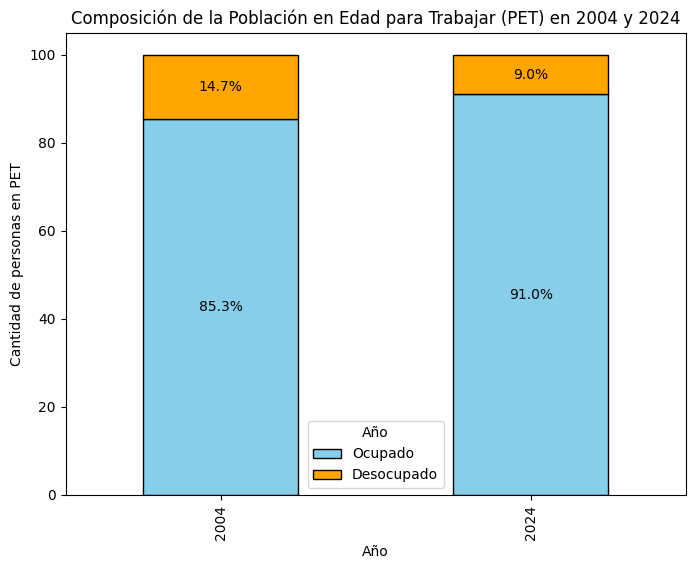

Proporción Ocupados PEA/PET en 2004: 1.0005
Proporción Desocupados PEA/PET en 2004: 0.9971
Proporción Ocupados PEA/PET en 2024: 1.0019
Proporción Desocupados PEA/PET en 2024: 0.9806


In [54]:
# Agregar la columna PET (Población en Edad para Trabajar)
respondieron['PET'] = respondieron['CH06'].apply(lambda x: 1 if 15 <= x <= 65 else 0)

# Ver las primeras filas para comprobar
respondieron[['CH06', 'PET']].head()

# Gráfico de barras por PET para 2004 y 2024
plt.figure(figsize=(10, 6))

# Filtrar los datos por año
df_2004_pet = respondieron[(respondieron['PET'] == 1) & (respondieron['PEA'] == 1) & (respondieron['ANO4'] == 2004)]
df_2024_pet = respondieron[(respondieron['PET'] == 1) & (respondieron['PEA'] == 1) & (respondieron['ANO4'] == 2024)]

# Calcular porcentajes para cada estado en 2004
pet_2004 = df_2004_pet['ESTADO'].value_counts(normalize=True) * 100

# Calcular porcentajes para cada estado en 2024
pet_2024 = df_2024_pet['ESTADO'].value_counts(normalize=True) * 100

# Crear un DataFrame con los datos combinados
df_barras_pet = pd.DataFrame({
    '2004': pet_2004,
    '2024': pet_2024
}).T  # Transponer para que los años sean las filas

# Renombrar columnas para que queden claras
df_barras_pet.rename(columns={1: 'Ocupado', 2: 'Desocupado'}, inplace=True)

# Crear el gráfico de barras apiladas
fig, ax = plt.subplots(figsize=(8, 6))
bars_pet = df_barras_pet.plot(kind='bar', stacked=True, ax=ax, color=['skyblue', 'orange'], edgecolor='black')

# Añadir los porcentajes en cada barra
for bar in bars_pet.patches:
    height = bar.get_height()  # Altura de cada segmento
    if height > 0:  # Solo mostrar texto si el segmento tiene valor
        width = bar.get_width()
        x = bar.get_x() + width / 2
        y = bar.get_y() + height / 2
        ax.text(x, y, f'{height:.1f}%', ha='center', va='center', fontsize=10, color='black')


plt.title('Composición de la Población en Edad para Trabajar (PET) en 2004 y 2024')
plt.xlabel('Año')
plt.ylabel('Cantidad de personas en PET')
plt.legend(title='Año')
plt.show()


# Comparación de las proporciones de PEA y PET para 2004 y 2024

pea_2004_ocupados_value = pea_2004.loc[1, ]
pet_2004_ocupados_value = pet_2004.loc[1, ]
pea_2004_desocupados_value = pea_2004.loc[2, ]
pet_2004_desocupados_value = pet_2004.loc[2, ]
pea_2024_ocupados_value = pea_2024.loc[1, ]
pet_2024_ocupados_value = pet_2024.loc[1, ]
pea_2024_desocupados_value = pea_2024.loc[2, ]
pet_2024_desocupados_value = pet_2024.loc[2, ]

pea_pet_comparison_ocupados_2004 = pea_2004_ocupados_value / pet_2004_ocupados_value
pea_pet_comparison_desocupados_2004 = pea_2004_desocupados_value / pet_2004_desocupados_value
pea_pet_comparison_ocupados_2024 = pea_2024_ocupados_value / pet_2024_ocupados_value
pea_pet_comparison_desocupados_2024 = pea_2024_desocupados_value / pet_2024_desocupados_value

print(f"Proporción Ocupados PEA/PET en 2004: {pea_pet_comparison_ocupados_2004:.4f}")
print(f"Proporción Desocupados PEA/PET en 2004: {pea_pet_comparison_desocupados_2004:.4f}")
print(f"Proporción Ocupados PEA/PET en 2024: {pea_pet_comparison_ocupados_2024:.4f}")
print(f"Proporción Desocupados PEA/PET en 2024: {pea_pet_comparison_desocupados_2024:.4f}")


#### 6.	Por ultimo, agreguen la base respondieron una columna llamada desocupado que tome 1 si esta desocupada. ¿Cuántas personas están desocupadas en 2004 vs 2024?

In [55]:
# Agregar la columna desocupado
respondieron['desocupado'] = respondieron['ESTADO'].apply(lambda x: 1 if x == 2 else 0)

# Verificar las primeras filas para asegurarse de que la columna está correctamente añadida
respondieron[['ESTADO', 'desocupado']].head()

# Calcular desocupados en 2004
desocupados_2004 = respondieron[(respondieron['desocupado'] == 1) & (respondieron['ANO4'] == 2004)].shape[0]

# Calcular desocupados en 2024
desocupados_2024 = respondieron[(respondieron['desocupado'] == 1) & (respondieron['ANO4'] == 2024)].shape[0]

# Mostrar los resultados
print(f"Cantidad de desocupados en 2004: {desocupados_2004}")
print(f"Cantidad de desocupados en 2024: {desocupados_2024}")

Cantidad de desocupados en 2004: 528
Cantidad de desocupados en 2024: 311


<ipython-input-55-a9f6709b6b15>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron['desocupado'] = respondieron['ESTADO'].apply(lambda x: 1 if x == 2 else 0)


##### 6a.	(Opcional) Muestre la proporción de desocupados por nivel educativo comparando 2004 vs 2024. ¿Hubo cambios de desocupados por nivel educativo?

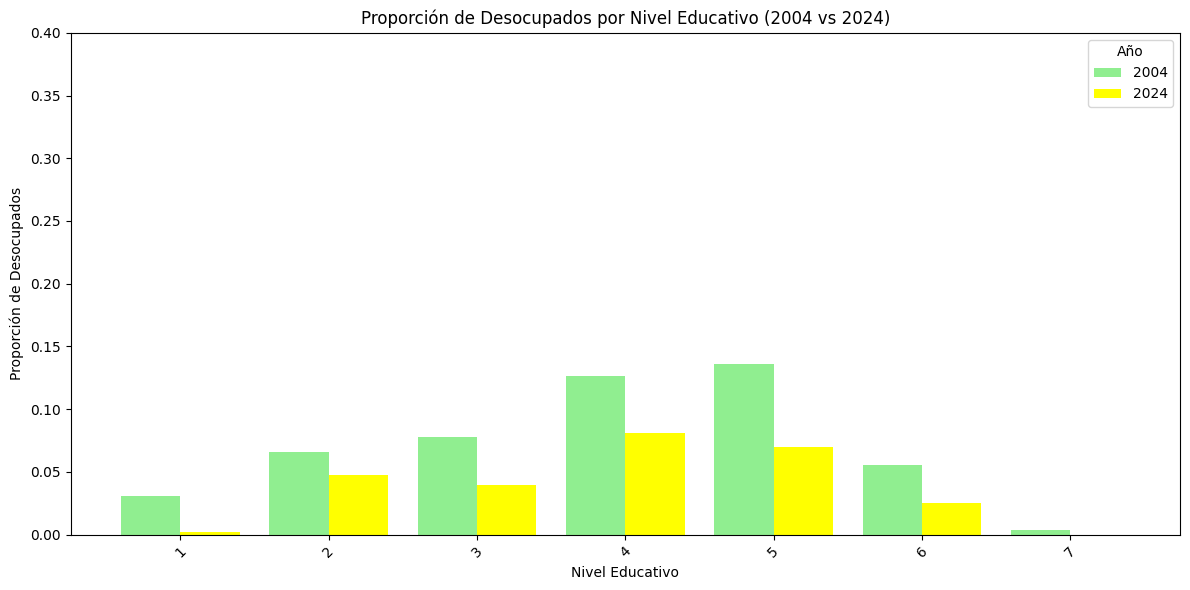

In [56]:
# Agrupar por nivel educativo y calcular la proporción de desocupados en cada grupo para 2004
desocupados_educacion_2004 = respondieron[respondieron['ANO4'] == 2004].groupby('NIVEL_ED')['desocupado'].mean()

# Agrupar por nivel educativo y calcular la proporción de desocupados en cada grupo para 2024
desocupados_educacion_2024 = respondieron[respondieron['ANO4'] == 2024].groupby('NIVEL_ED')['desocupado'].mean()

# # Graficar la comparación de las proporciones
# plt.figure(figsize=(12, 6))

# # Para 2004
# sns.barplot(x=desocupados_educacion_2004.index, y=desocupados_educacion_2004.values, color='skyblue', label='2004')

# # Para 2024
# sns.barplot(x=desocupados_educacion_2024.index, y=desocupados_educacion_2024.values, color='orange', label='2024')

# plt.title('Proporción de Desocupados por Nivel Educativo (2004 vs 2024)')
# plt.xlabel('Nivel Educativo')
# plt.ylabel('Proporción de Desocupados')
# plt.legend(title='Año')
# plt.xticks(rotation=45)
# plt.show()


# Crear un DataFrame combinado para facilitar el gráfico
df_educacion = pd.DataFrame({
    '2004': desocupados_educacion_2004,
    '2024': desocupados_educacion_2024
}).reset_index()

# Crear el gráfico de barras agrupadas
plt.figure(figsize=(12, 6))

bar_width = 0.4  # Ancho de las barras
x = range(len(df_educacion))  # Posiciones en el eje X

# Barras para 2004
plt.bar(
    [pos - bar_width / 2 for pos in x],  # Desplazar hacia la izquierda
    df_educacion['2004'],
    width=bar_width,
    color='lightgreen',
    label='2004'
)

# Barras para 2024
plt.bar(
    [pos + bar_width / 2 for pos in x],  # Desplazar hacia la derecha
    df_educacion['2024'],
    width=bar_width,
    color='yellow',
    label='2024'
)

# Personalizar el gráfico
plt.title('Proporción de Desocupados por Nivel Educativo (2004 vs 2024)')
plt.xlabel('Nivel Educativo')
plt.ylabel('Proporción de Desocupados')
plt.xticks(x, df_educacion['NIVEL_ED'], rotation=45)  # Etiquetas en el eje X
plt.legend(title='Año')
plt.ylim(0, 0.4)  # Límite del eje Y ajustado
plt.tight_layout()

# Mostrar el gráfico
plt.show()

##### b.	(Opcional) Cree una variable categórica de años cumplidos (CH06) agrupada de a 10 años. Muestre proporción de desocupados por edad agrupada comparando 2004 vs 2024. ¿Hubo cambios de desocupados por edad?

In [57]:
#print(respondieron['CH06'].describe())  # Ver estadísticos básicos
print(respondieron['CH06'].unique())

[79.  67.  74.  54.  51.  25.  20.  55.  48.  17.  15.  77.  50.  49.
 26.  22.  18.  86.  62.  76.  45.  41.  21.  31.  19.  52.  12.  32.
 29.  64.  10.  47.  43.  13.   3.  46.  78.  60.  59.  37.  44.  30.
 63.  71.  87.  34.  14.  24.  28.  27.  69.  56.  33.  66.  61.   1.
 92.   0.5 65.  57.  23.   4.  40.  16.   9.  83.   6.  38.  75.  11.
 53.  73.  39.  35.   7.   5.  36.   8.  82.  85.  72.  70.  89.  42.
  2.  58.  68.  81.  80.  93.  96.  84.  90.  94.  88.  99.  91.  95.
 97. ]


<ipython-input-58-4495b1b76f54>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron['edad_grupo'] = pd.cut(respondieron['CH06'],
<ipython-input-58-4495b1b76f54>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  desocupados_edad_2004 = respondieron[respondieron['ANO4'] == 2004].groupby('edad_grupo')['desocupado'].mean()
<ipython-input-58-4495b1b76f54>:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the fu

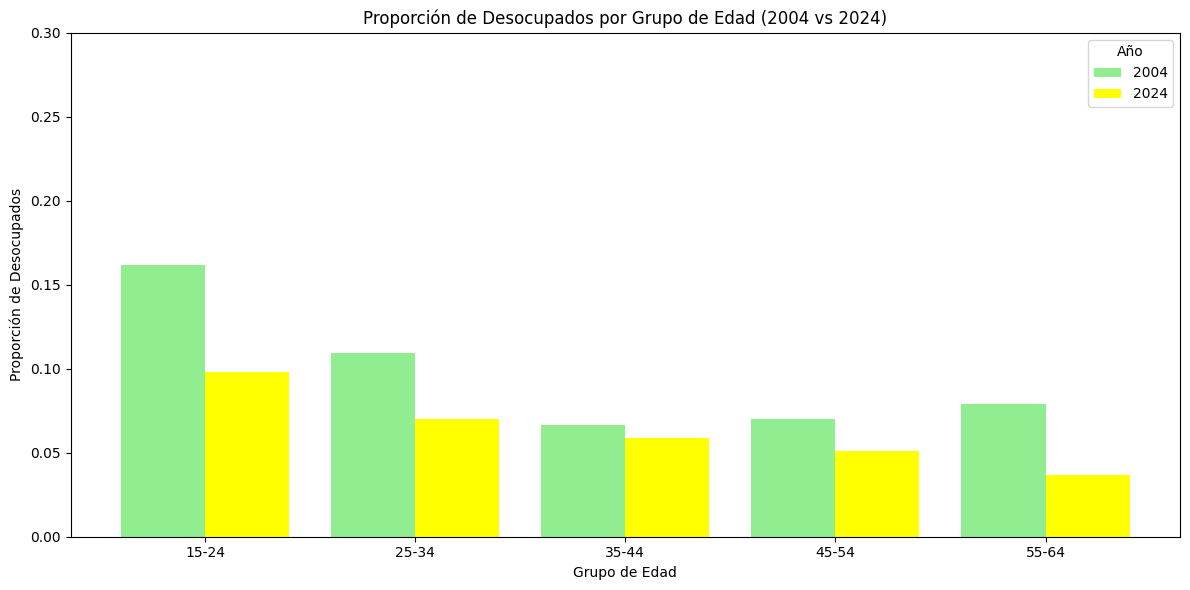

In [58]:
# Crear la variable de edad agrupada en rangos de 10 años
respondieron['edad_grupo'] = pd.cut(respondieron['CH06'],
                                    bins=[15, 25, 35, 45, 55, 65],
                                    right=False,
                                    labels=["15-24", "25-34", "35-44", "45-54", "55-64"])

# Verificar los primeros valores
respondieron[['CH06', 'edad_grupo']].head()

# Proporción de desocupados por edad para 2004
desocupados_edad_2004 = respondieron[respondieron['ANO4'] == 2004].groupby('edad_grupo')['desocupado'].mean()

# Proporción de desocupados por edad para 2024
desocupados_edad_2024 = respondieron[respondieron['ANO4'] == 2024].groupby('edad_grupo')['desocupado'].mean()

# Crear un DataFrame combinado para facilitar el gráfico
df_comparacion = pd.DataFrame({
    '2004': desocupados_edad_2004,
    '2024': desocupados_edad_2024
}).reset_index()

# Crear el gráfico de barras agrupadas
plt.figure(figsize=(12, 6))

bar_width = 0.4  # Ancho de las barras
x = range(len(df_comparacion))  # Posiciones en el eje X

# Barras para 2004
plt.bar(
    [pos - bar_width / 2 for pos in x],  # Desplazar hacia la izquierda
    df_comparacion['2004'],
    width=bar_width,
    color='lightgreen',
    label='2004'
)

# Barras para 2024
plt.bar(
    [pos + bar_width / 2 for pos in x],  # Desplazar hacia la derecha
    df_comparacion['2024'],
    width=bar_width,
    color='yellow',
    label='2024'
)

# Personalizar el gráfico
plt.title('Proporción de Desocupados por Grupo de Edad (2004 vs 2024)')
plt.xlabel('Grupo de Edad')
plt.ylabel('Proporción de Desocupados')
plt.xticks(x, df_comparacion['edad_grupo'])  # Etiquetas en el eje X
plt.legend(title='Año')
plt.ylim(0, 0.3)  # Escala de proporciones (0 a 1)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

#### 7.	(Opcional) Dos tasas de desocupación: calcule la tasa de desocupación para CABA en 2004 y 2024 siguiendo la definición del INDEC. En economía laboral, muchas veces se argumenta que participar del mercado laboral (PEA=1) es una decisión endógena de los individuos y no quisiéramos que el indicador de la tasa de desocupación varíe por dicha decisión. Calcule la tasa de desocupación alternativa como el porcentaje de desocupados respecto de la PET. Presente en una tabla o gráfico la tasa de desocupación del INDEC y de economía laboral para 2004 y 2024 y comente los resultados. ¿Cuáles son las ventajas y desventajas de dichas mediciones?

In [ ]:
# Calcular tasa de desocupación para 2004
tasa_desocupacion_2004 = (desocupados_2004 / df_2004_pea) * 100

# Calcular tasa de desocupación para 2024
tasa_desocupacion_2024 = (desocupados_2024 / df_2024_pea) * 100

# Mostrar las tasas de desocupación
print(f"Tasa de desocupación INDEC 2004: {tasa_desocupacion_2004:.2f}%")
print(f"Tasa de desocupación INDEC 2024: {tasa_desocupacion_2024:.2f}%")


In [ ]:
# Calcular tasa alternativa de desocupación para 2004
tasa_desocupacion_alt_2004 = (desocupados_2004 / df_2004_pet) * 100

# Calcular tasa alternativa de desocupación para 2024
tasa_desocupacion_alt_2024 = (desocupados_2024 / df_2024_pet) * 100

# Mostrar las tasas alternativas de desocupación
print(f"Tasa alternativa de desocupación 2004: {tasa_desocupacion_alt_2004:.2f}%")
print(f"Tasa alternativa de desocupación 2024: {tasa_desocupacion_alt_2024:.2f}%")


In [ ]:
# Crear un DataFrame para comparar las tasas
tasa_comparacion = pd.DataFrame({
    'Tasa INDEC': [tasa_desocupacion_2004, tasa_desocupacion_2024],
    'Tasa Alternativa': [tasa_desocupacion_alt_2004, tasa_desocupacion_alt_2024]
}, index=['2004', '2024'])

print(tasa_comparacion)
